In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
import scipy as sp
import pandas as pd
import umap.umap_ as umap
import hdbscan

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### multiIndexing

In [24]:
# https://stackoverflow.com/questions/36760414/how-to-create-pandas-dataframes-with-more-than-2-dimensions
# https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-xs
channels = np.arange(64)
n_timepoints = 2000
n_targets = 12
n_blocks = 45
# n_subjects = 46
subject_block_target_time_channel = np.tile(channels, (n_blocks,n_targets,n_timepoints,1))
print(subject_block_target_time_channel.shape,np.product(subject_block_target_time_channel.shape[:-1]))

timepoints = np.arange(n_timepoints)
targets = range(n_targets)
blocks = range(n_blocks)
# subjects = range(n_subjects)

(45, 12, 64, 2000) 34560


In [25]:
multi_index = pd.MultiIndex.from_product([timepoints,targets,blocks][::-1],names=["time", "target", "block"][::-1])
multi_index.shape

(1080000,)

In [26]:
test_df = pd.DataFrame(subject_block_target_time_channel.reshape(-1,64),index=multi_index,columns=channels)

In [27]:
subject_idx = 0
subject_emg_stacks = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")

In [28]:
subject_emg_stacks.shape

(45, 12, 64, 2000)

In [32]:
df = pd.DataFrame(subject_emg_stacks.transpose(0,1,3,2).reshape(-1,64),index=multi_index,columns=channels).dropna()

In [19]:
del subject_emg_stacks

In [33]:
df

0         1         2         3         4         5   \
block target time                                                               
0     0      0     0.119860  0.114903  0.105453  0.284892  0.106697  0.090704   
             1     0.121780  0.116193  0.105970  0.299633  0.106381  0.090690   
             2     0.123673  0.117641  0.106542  0.313089  0.106062  0.090661   
             3     0.125470  0.119209  0.107127  0.324845  0.105744  0.090624   
             4     0.127119  0.120859  0.107688  0.334530  0.105437  0.090587   
...                     ...       ...       ...       ...       ...       ...   
44    11     83    1.131451  1.270162  0.584651  0.400142  0.275130  0.178640   
             84    1.138224  1.275533  0.592446  0.400007  0.273122  0.178407   
             85    1.144130  1.279910  0.599470  0.400079  0.271338  0.178430   
             86    1.149256  1.283437  0.605677  0.400428  0.269853  0.178748   
             87    1.153700  1.286268  0.611031  0.401129  0.268751  0.179403   

                         6         7         8         9   ...        54  \
block target time                                          ...             
0     0      0     0.132654  0.139421  0.137134  0.127521  ...  0.146309   
             1     0.133166  0.139199  0.139948  0.128833  ...  0.155933   
             2     0.133565  0.138963  0.143137  0.130432  ...  0.165141   
             3     0.133842  0.138725  0.146621  0.132246  ...  0.173683   
             4     0.133990  0.138497  0.150326  0.134206  ...  0.181327   
...                     ...       ...       ...       ...  ...       ...   
44    11     83    0.270993  0.347273  1.192827  1.082909  ...  0.407457   
             84    0.271941  0.350360  1.193045  1.084177  ...  0.412344   
             85    0.272999  0.353783  1.193756  1.084249  ...  0.417299   
             86    0.274272  0.357610  1.195013  1.083291  ...  0.422314   
             87    0.275877  0.361913  1.196814  1.081493  ...  0.427378   

                         55            56        57        58        59  \
block target time                                                         
0     0      0     0.152840  1.838962e-17  0.098399  0.101986  0.198955   
             1     0.162466 -1.573280e-19  0.099933  0.103261  0.199908   
             2     0.171568 -4.415515e-17  0.101586  0.104685  0.200593   
             3     0.179908 -3.777972e-17  0.103333  0.106246  0.201000   
             4     0.187271 -5.385683e-17  0.105155  0.107938  0.201137   
...                     ...           ...       ...       ...       ...   
44    11     83    0.374065  4.461375e-17  0.513206  0.518841  0.656239   
             84    0.380843  1.687293e-16  0.516008  0.520097  0.661362   
             85    0.388095  3.125138e-16  0.518442  0.521231  0.665967   
             86    0.395789  1.151840e-16  0.520560  0.522349  0.670064   
             87    0.403889  7.212957e-17  0.522421  0.523562  0.673687   

                         60        61        62        63  
block target time                                          
0     0      0     0.120979  0.105677  0.078718  0.107798  
             1     0.122062  0.107824  0.081468  0.112954  
             2     0.122967  0.109856  0.084162  0.118047  
             3     0.123670  0.111724  0.086729  0.122947  
             4     0.124164  0.113385  0.089107  0.127530  
...                     ...       ...       ...       ...  
44    11     83    0.529314  0.468768  0.381233  0.421754  
             84    0.534529  0.473563  0.383668  0.426955  
             85    0.539654  0.478005  0.386273  0.432343  
             86    0.544722  0.482098  0.389071  0.437892  
             87    0.549765  0.485859  0.392071  0.443568  

[143220 rows x 64 columns]

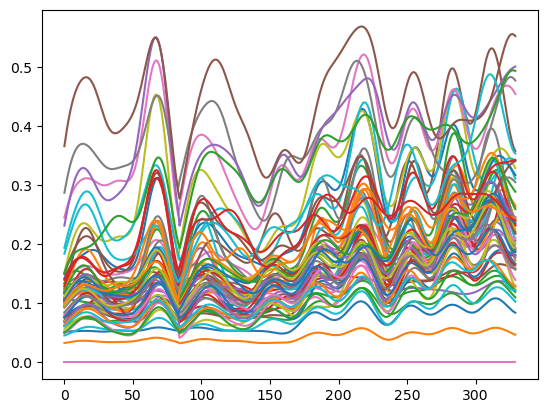

In [34]:
for ch in channels:
    plt.plot(df.xs(0,level="block").xs(1,level="target")[ch])

In [45]:
def name_to_color(index_list):
    numbers = np.array([int(el.split(" ")[-1]) for el in index_list])
    return numbers / numbers.max()

def index_to_color(numbers):
    return np.array(numbers) / np.max(numbers)

def map_to_range(output_range, array):
    min = array.min()
    max = array.max()
    return output_range[0] + ((array - min)*(output_range[1]-output_range[0])) / (max - min)

In [49]:
# https://pair-code.github.io/understanding-umap/
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
reducer = umap.UMAP(n_components=2,n_neighbors=10,min_dist=0.0)
embedding = reducer.fit_transform(df)

KeyboardInterrupt: 

In [ ]:
embedding_df = pd.DataFrame(embedding)
del embedding

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='0', ylabel='1'>

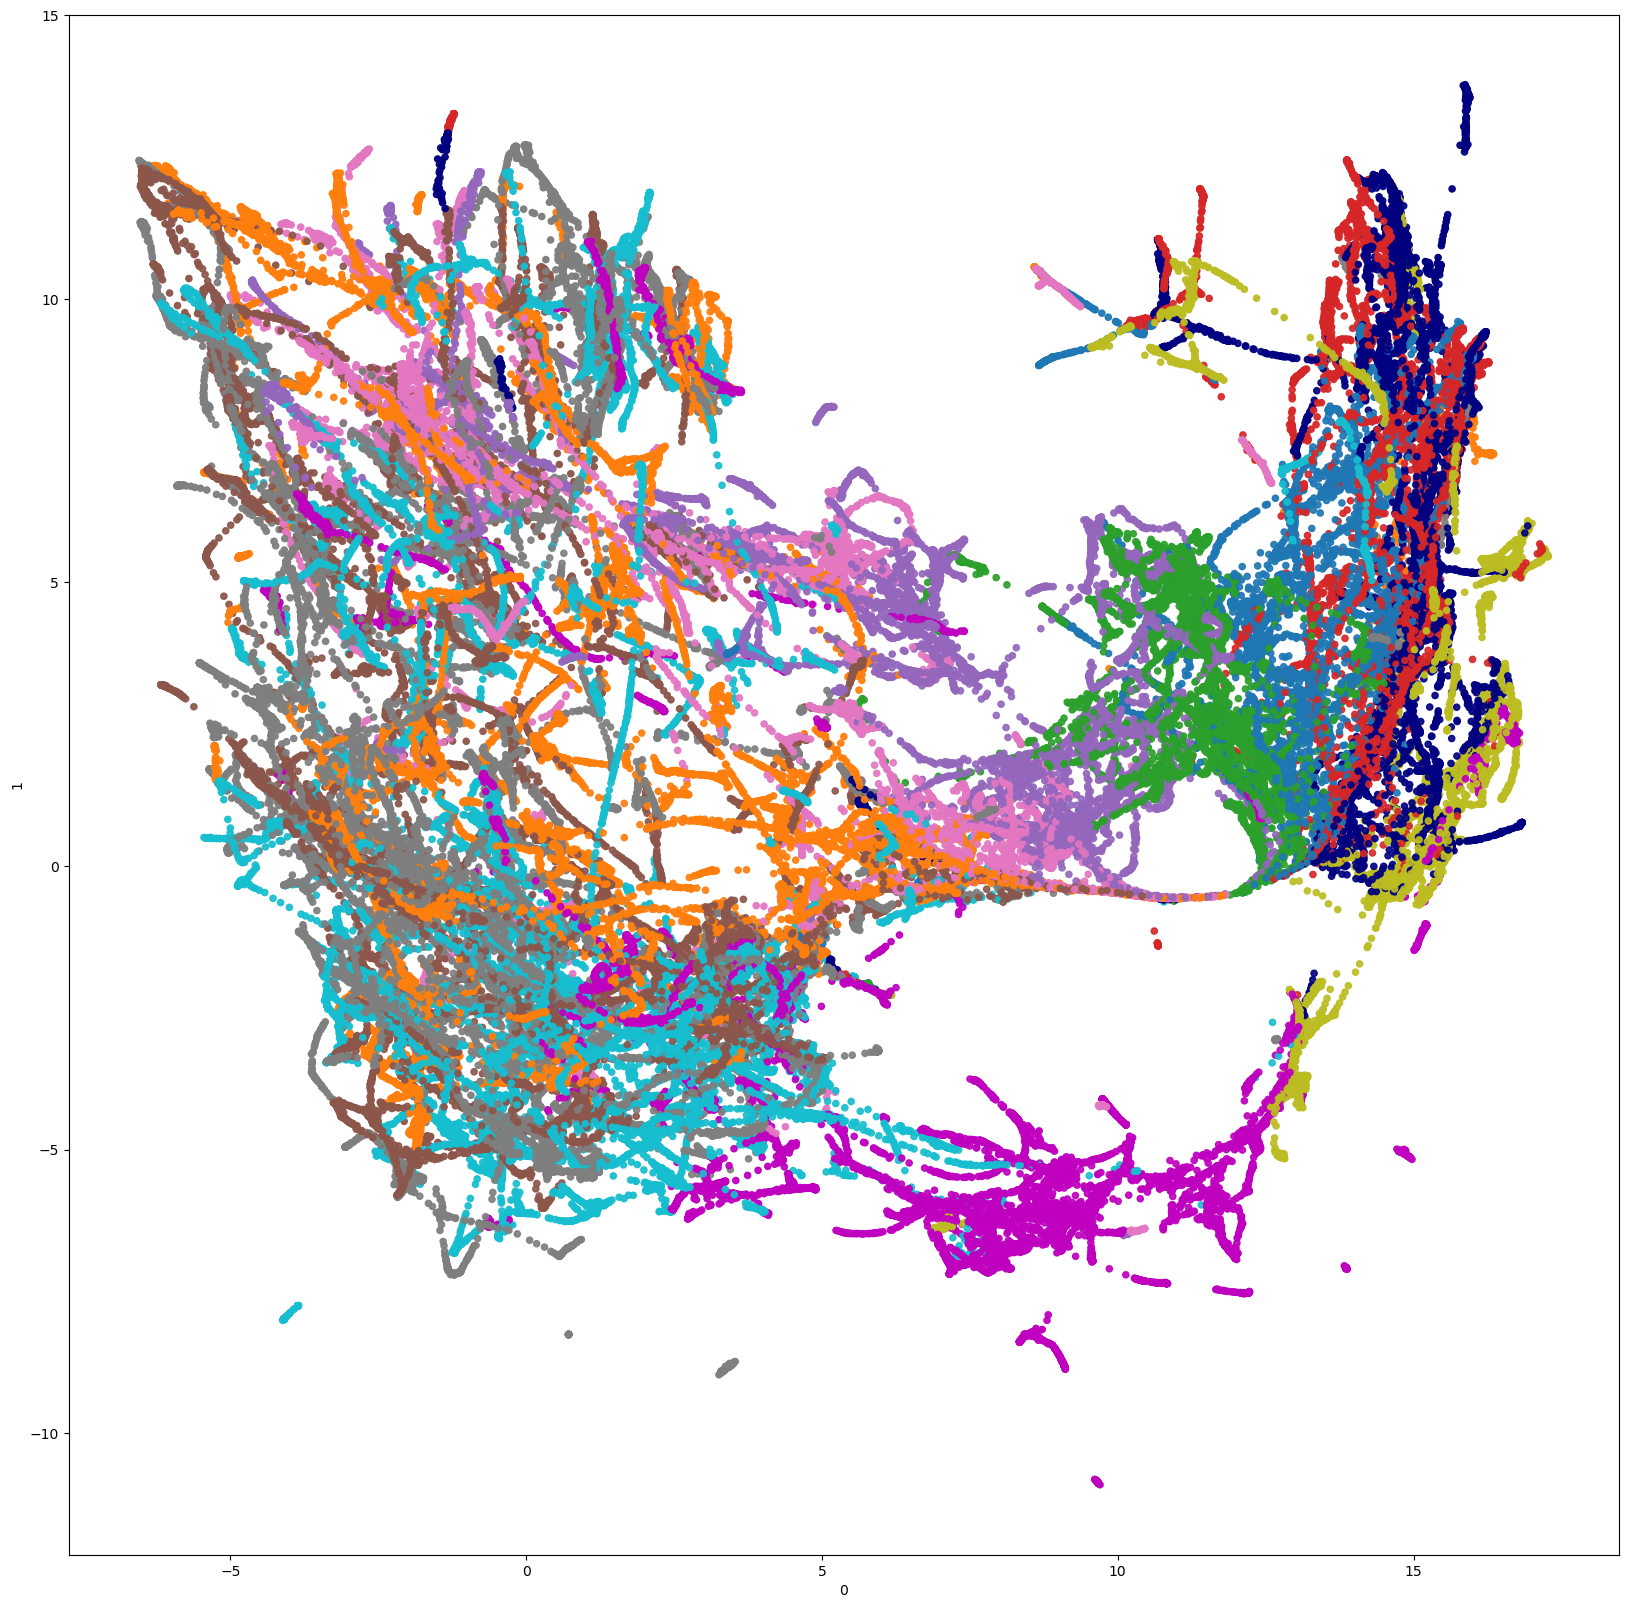

In [ ]:
# block is color
# alpha is time
colors = ["tab:red","tab:blue","tab:green","tab:purple","tab:pink","tab:orange","tab:brown","tab:grey","tab:cyan","m","tab:olive","navy"]
block_names = df.index.get_level_values("block").tolist()
target_names = df.index.get_level_values("target").tolist()
time_indices = np.array(df.index.get_level_values("time").tolist())
embedding_df.plot(kind="scatter",x=0,y=1,c=[colors[i] for i in target_names],colormap="Set3",figsize=(20,20),alpha=map_to_range([0.9,1.0],time_indices))

<Axes: xlabel='0', ylabel='1'>

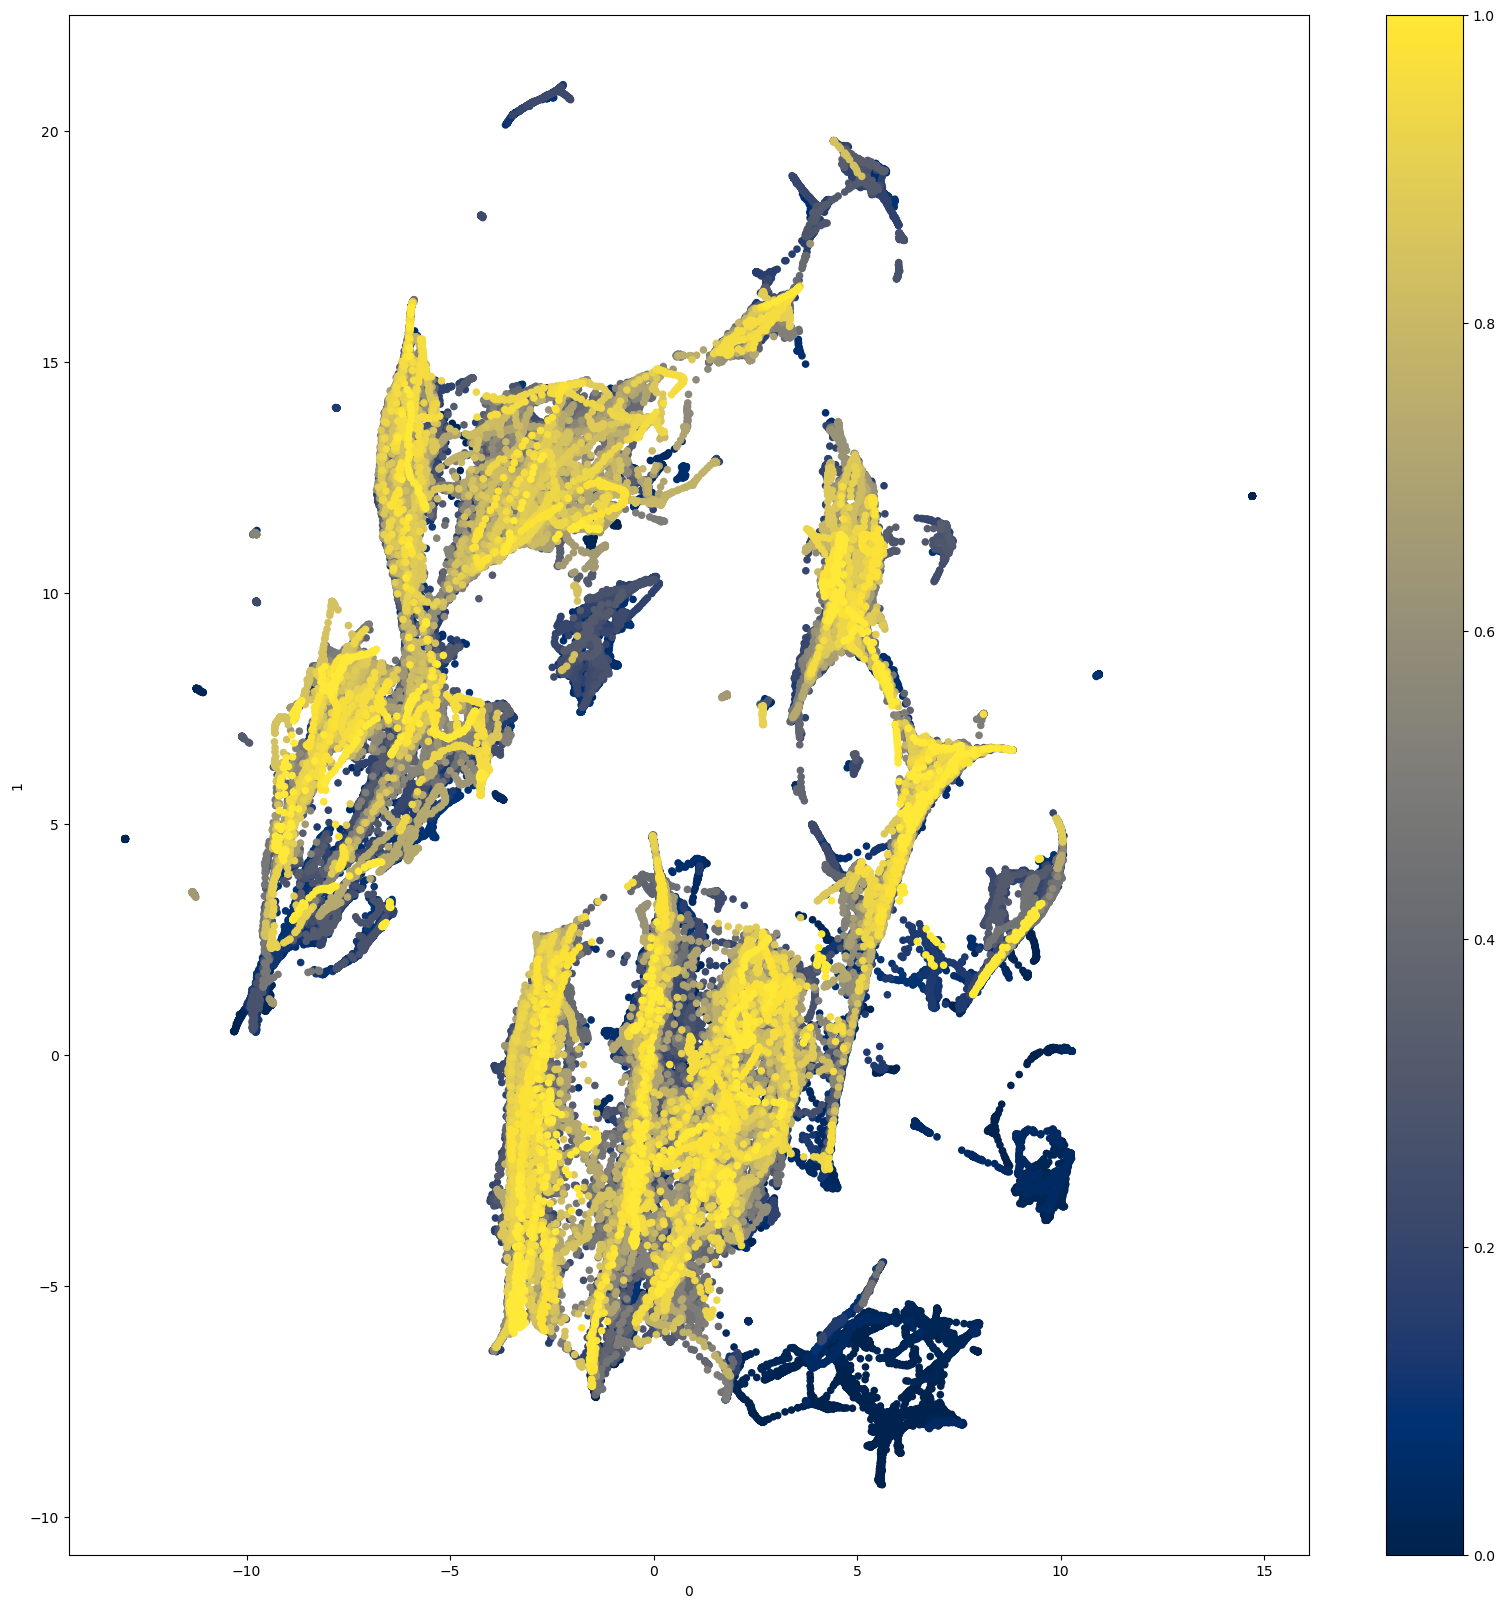

In [ ]:
embedding_df.plot(kind="scatter",x=0,y=1,c=index_to_color(block_names),colormap="cividis",figsize=(20,20))

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200)
clusterer.fit(embedding_df)
print("num clusters: ", clusterer.labels_.max())

num clusters:  30


In [ ]:
df.xs(subject_number, level="subject")["label"] = clusterer.labels_[:]

<Axes: xlabel='0', ylabel='1'>

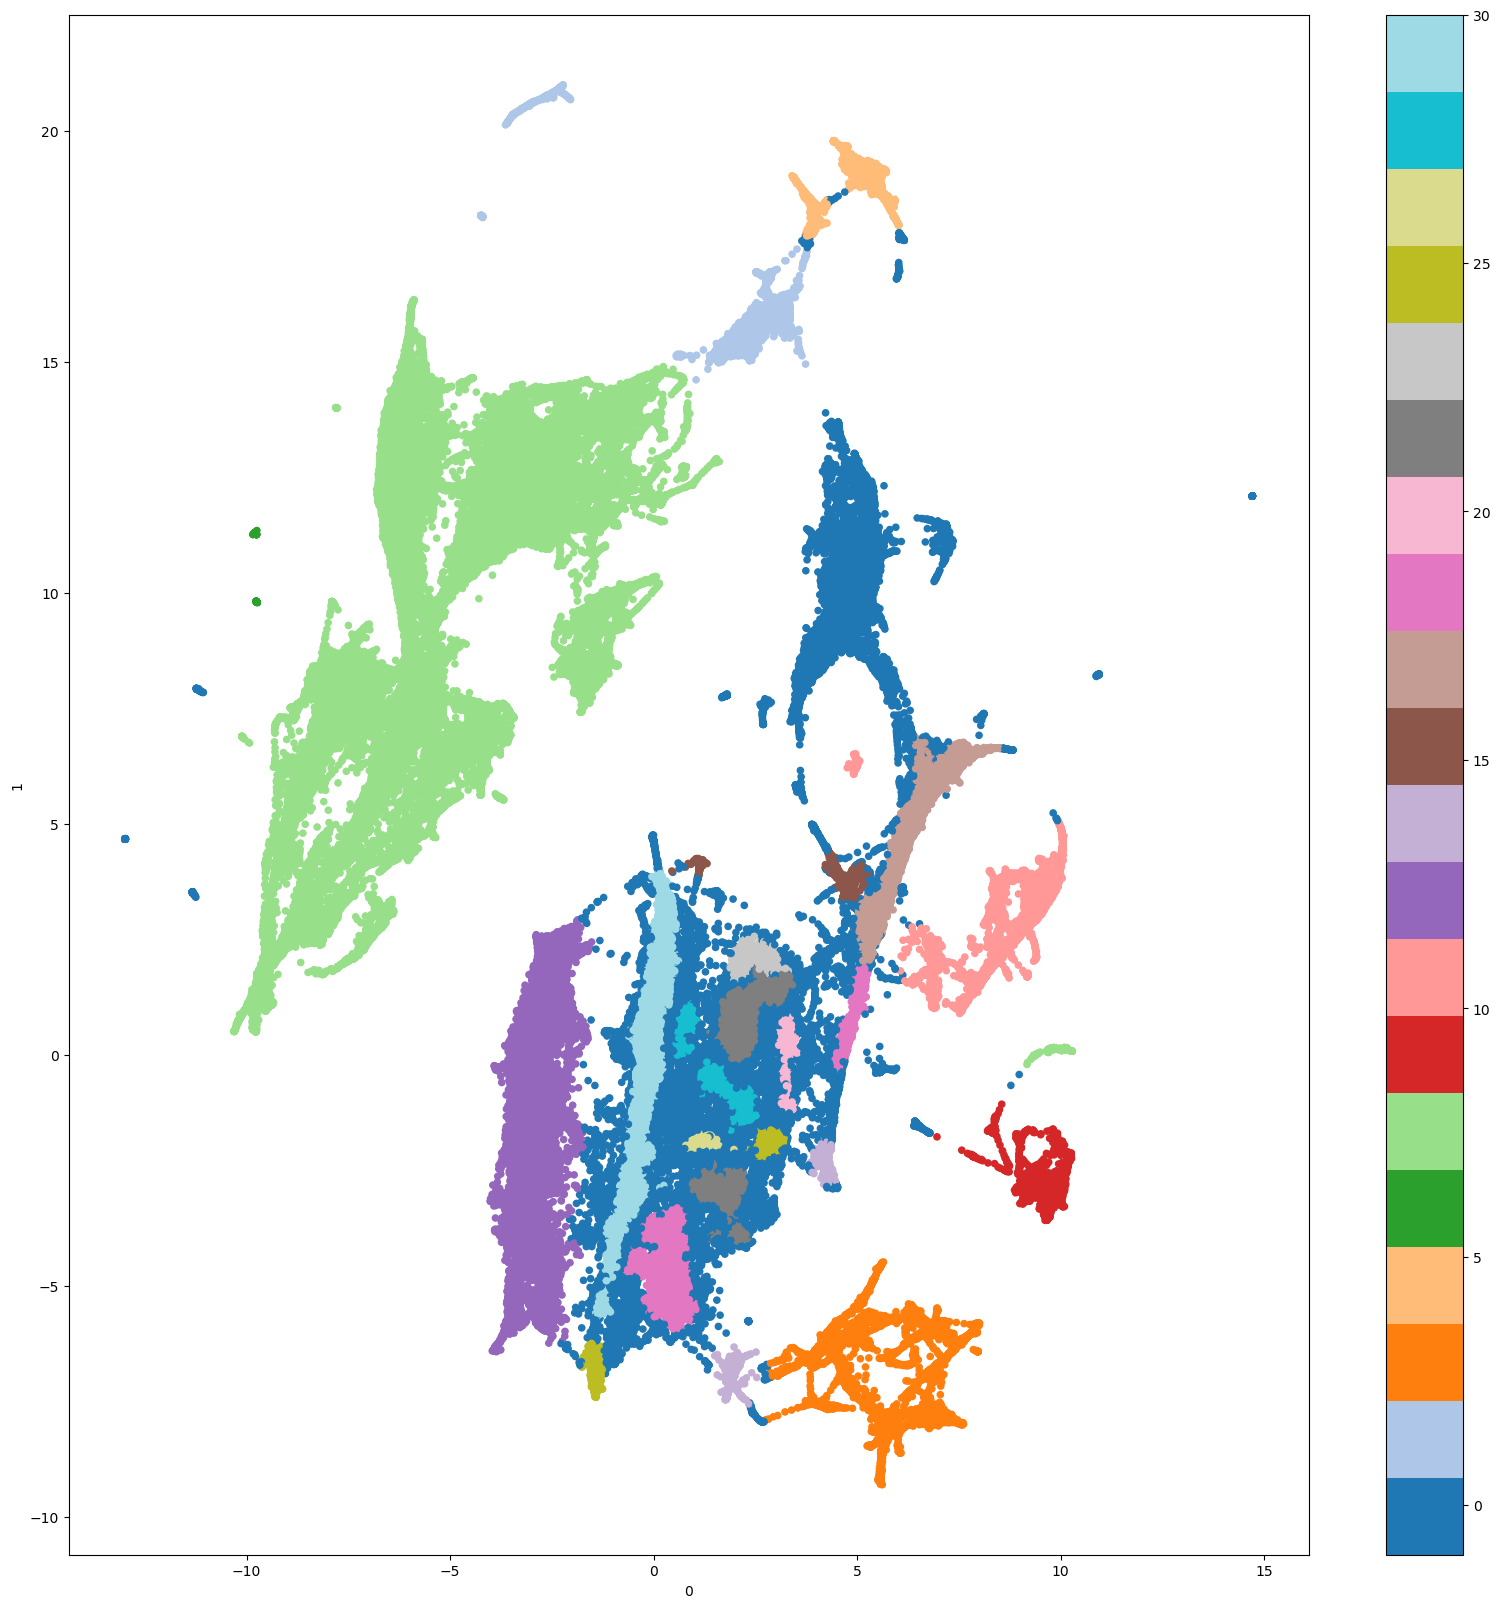

In [ ]:
embedding_df.plot(kind="scatter",x=0,y=1,c=clusterer.labels_,colormap="tab20",figsize=(20,20))

### rewards are lognormal

0.015630630402002434 5.621566189582623


<Axes: >

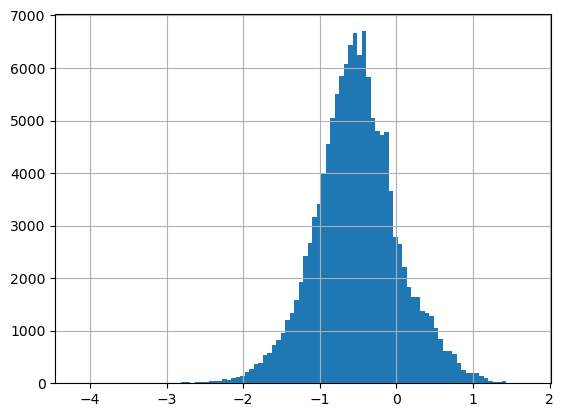

In [61]:
print(rewards.min(), rewards.max())
np.log(rewards).hist(bins=100)

<Axes: xlabel='0', ylabel='1'>

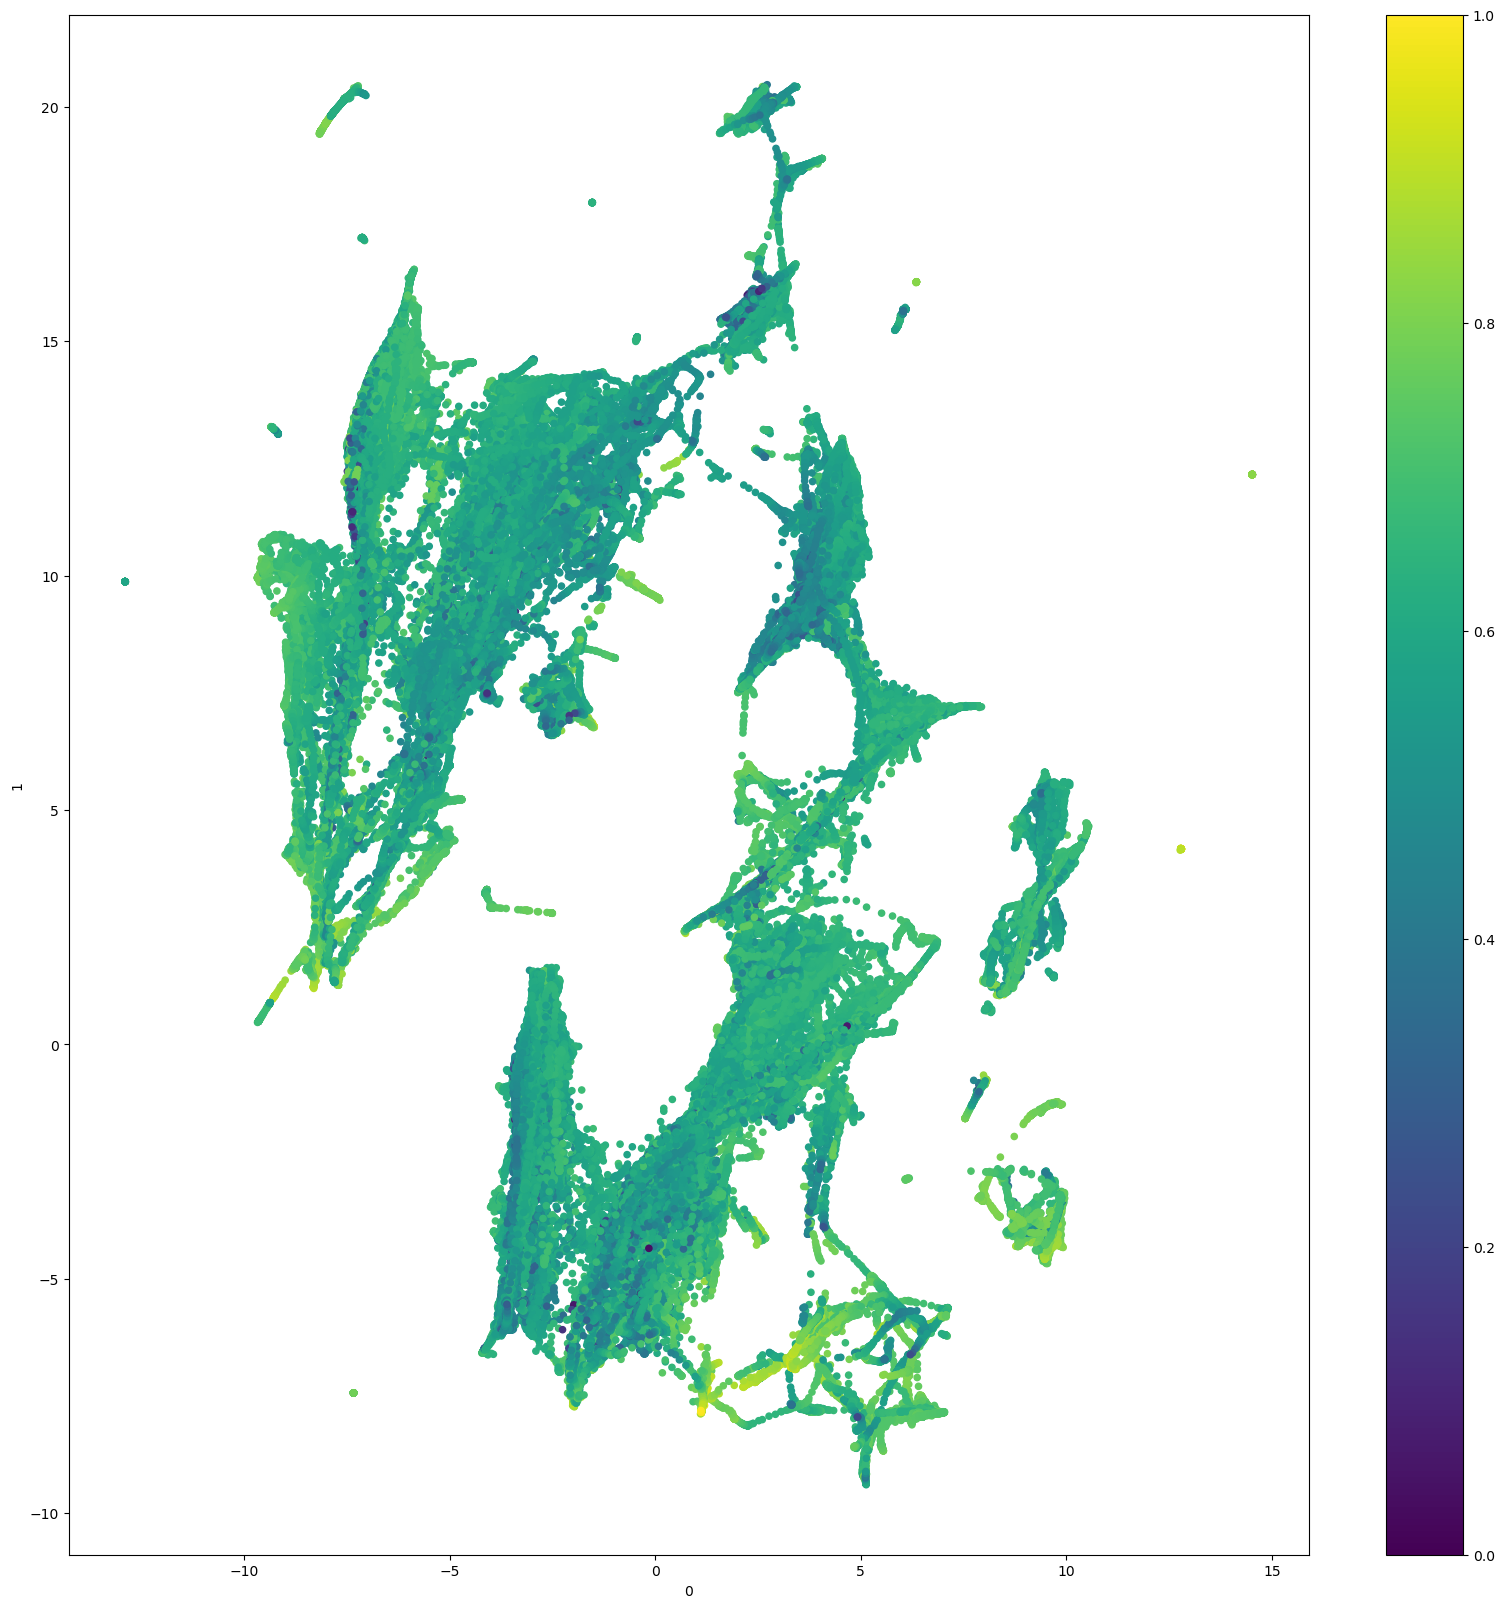

In [59]:
trajectory_df = pd.read_pickle("trajectory_dataframe.pkl")
rewards = trajectory_df.xs(subject_number, level="subject")["reward"]
embedding_df.plot(kind="scatter",x=0,y=1,c=map_to_range([0.,1.0],np.log(rewards)),colormap="viridis",figsize=(20,20))

## Notes 

- Time seems to "compress" the data, becoming more similar (closer on the manifold) over time?
- Time encompasses more clusters, so more information than just time
- Targets aren't well separated into clusters, so what are the clusters?
- What correlates with cluster labels?
    - Signal mean, covariance
    - Reward 